In [94]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt

from napari_convpaint.conv_paint import ConvPaintWidget
from napari_convpaint.conv_paint_utils import (Hookmodel, filter_image_multioutputs, get_features_current_layers, get_multiscale_features, train_classifier, predict_image)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create predictions/segmentations with Convpaint on the cellpose dataset (wit self-created scribbles)

In [ ]:
def selfpred_convpaint(image, labels, layer_list, scalings):
    # Ensure right shape and dimension order
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = np.moveaxis(image, -1, 0) # ConvPaint expects (C, H, W)
    # Define the model
    model = Hookmodel(model_name='vgg16')
    # Ensure the layers are given as a list
    if isinstance(layer_list, int):
        layer_list = [layer_list]
    # Read out the layer names
    all_layers = [key for key in model.module_dict.keys()]
    layers = [all_layers[i] for i in layer_list]
    # Register the hooks for the selected layers
    model.register_hooks(selected_layers=layers)
    # Get the features and targets
    features, targets = get_features_current_layers(
        model=model, image=image, annotations=labels, scalings=scalings,
        order=1, use_min_features=False, image_downsample=1)
    # Train the classifier
    random_forest = train_classifier(features, targets)
    # Predict on the image
    predicted = predict_image(
        image, model, random_forest, scalings=scalings,
        order=1, use_min_features=False, image_downsample=1)
    return predicted

In [ ]:
def pred_cellpose_convpaint(folder_path, img_num, mode, bin, layer_list=[0], scalings=[1,2], save_res=False, show_res=False):
    # Define the paths
    image_base = f"{folder_path}/{str(img_num).zfill(3)}"
    image_path = image_base + "_img.png"
    ground_truth_path = image_base + "_ground_truth.png"
    scribbles_path = image_base + f"_scribbles_{mode}_{bin}.png"    
    # Read the images
    ground_truth = np.array(Image.open(ground_truth_path))
    image = np.array(Image.open(image_path))
    labels = np.array(Image.open(scribbles_path))

    # Predict the image
    prediction = selfpred_convpaint(image, labels, layer_list, scalings)

    # Calculate stats
    acc = np.mean(ground_truth == prediction)
    perc_labelled = np.sum(labels>0) / (labels.shape[0] * labels.shape[1]) * 100

    if save_res:
        # Save the scribble annotation as an image
        pred_image = Image.fromarray(prediction)
        pred_path = image_path + f"_convpaint_{mode}_{bin}.png"
        pred_image.save(pred_path)

    if show_res:
        # Show the ground truth and the scribble annotation
        v = napari.Viewer()
        v.add_image(image)
        v.add_labels(ground_truth)
        v.add_labels(labels)
        v.add_labels(prediction)

    return prediction

In [ ]:
folder_path = "./imgs/train"
mode = "all"
layer_list = [0]
scalings = [1, 2]

for bin in [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]:
    for img_num in range(0, 5):
        pred = pred_cellpose_convpaint(folder_path, img_num, mode, bin, layer_list, scalings, save_res=True, show_res=False)

## Analyse the created scribbles and segmentations (perc. labelled vs. acc.) from saved files

In [ ]:
def analyse_cellpose_single_file(folder_path, img_num, mode, bin, model="convpaint", show_res=False):
    # Define the paths
    image_base = f"{folder_path}/{str(img_num).zfill(3)}"
    image_path = image_base + "_img.png"
    ground_truth_path = image_base + "_ground_truth.png"
    scribbles_path = image_base + f"_scribbles_{mode}_{bin}.png"
    pred_path = image_path + f"_{model}_{mode}_{bin}.png"
    # Read the images
    ground_truth = np.array(Image.open(ground_truth_path))
    image = np.array(Image.open(image_path))
    labels = np.array(Image.open(scribbles_path))
    prediction = np.array(Image.open(pred_path))

    # Calculate stats
    acc = np.mean(ground_truth == prediction)
    perc_labelled = np.sum(labels>0) / (labels.shape[0] * labels.shape[1]) * 100

    if show_res:
        # Show the ground truth and the scribble annotation
        v = napari.Viewer()
        v.add_image(image)
        v.add_labels(ground_truth)
        v.add_labels(labels)
        v.add_labels(prediction)

    res = pd.DataFrame({'image': image_path,
                            'ground truth': ground_truth_path,
                            'scribbles': scribbles_path,
                            'prediction': pred_path,
                            'mode': mode,
                            'bin': bin,
                            'perc. labelled': perc_labelled,
                            'accuracy': acc}, index=[0])
    
    return res
    

In [104]:
folder_path = "./imgs/train"
mode = "all"
df = pd.DataFrame(columns=['image', 'ground truth', 'scribbles', 'prediction', 'mode', 'bin', 'perc. labelled', 'accuracy'])
for bin in [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1]:
    for img_num in range(0, 5):
        res = analyse_cellpose_single_file(folder_path, img_num, mode, bin, model="convpaint", show_res=False)
        df = pd.concat([df, res], ignore_index=True)

C:\Users\roman\AppData\Local\Temp\ipykernel_13808\63742213.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, res], ignore_index=True)


In [105]:
df[:5]

,image,ground truth,scribbles,prediction,mode,bin,perc. labelled,accuracy
0,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01.png,./imgs/train/000_img.png_convpaint_all_0.01.png,all,0.01,0.008669,0.905847
1,./imgs/train/001_img.png,./imgs/train/001_ground_truth.png,./imgs/train/001_scribbles_all_0.01.png,./imgs/train/001_img.png_convpaint_all_0.01.png,all,0.01,0.008669,0.866621
2,./imgs/train/002_img.png,./imgs/train/002_ground_truth.png,./imgs/train/002_scribbles_all_0.01.png,./imgs/train/002_img.png_convpaint_all_0.01.png,all,0.01,0.007649,0.925526
3,./imgs/train/003_img.png,./imgs/train/003_ground_truth.png,./imgs/train/003_scribbles_all_0.01.png,./imgs/train/003_img.png_convpaint_all_0.01.png,all,0.01,0.008669,0.799914
4,./imgs/train/004_img.png,./imgs/train/004_ground_truth.png,./imgs/train/004_scribbles_all_0.01.png,./imgs/train/004_img.png_convpaint_all_0.01.png,all,0.01,0.007649,0.772040


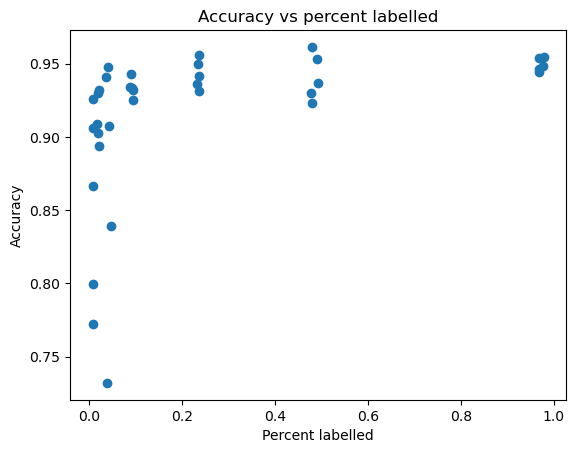

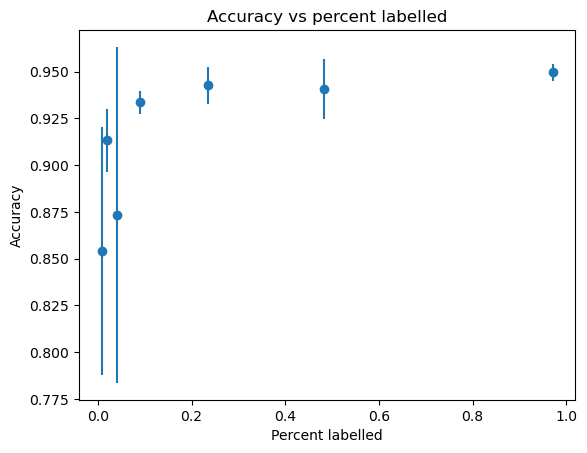

In [106]:
# Plot accuracy vs percent labelled
plt.figure()

# Scatterplot
plt.scatter(df['perc. labelled'], df['accuracy'])
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.show()

# Grouped plot
# For each bin, take the mean and standard deviation of the accuracy and plot it versurs the percent labelled
df_grouped = df.groupby('bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='o')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.show()
